In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import math
import matplotlib.patches as mpatches
plt.rcParams['axes.unicode_minus'] = False  

In [6]:
# 傳入 stage, 回傳 Reward 與下一階段的 State）
def get_enviroment(state, action):
    stage = state[0]
    inventory_level = state[1]
    duration = state[2]
    
    print("current_stage: ", stage)
    print("current_inventory_level: ", inventory_level)
    print("current_duration: ", duration)
    
    random_rate = random.random()
    order_num = int(random.gauss(mu=MU,sigma=SIG))
    print("order_num",order_num)
    
    if action == 0:
        print("keep producing")
        new_stage = stage + 1 if MACHINE_DETERIORATION_RATE[stage]>random_rate else stage
        new_inventory_level = inventory_level + int(MACHINE_YIELD_RATE[new_stage] * MACHINE_PRODUCTION_NUM) - order_num
        new_duration = 0
    elif action == 1:
        print("preventive maintenance")
        new_stage = stage - 2 if stage > 2 else 0
        new_inventory_level = inventory_level - order_num
        new_duration = PM_DURATION
    elif action == 2:
        print("corrective maintenance")
        new_stage = 0
        new_inventory_level = inventory_level - order_num
        new_duration = CM_DURATION
    elif action==3:
        print("under maintenance")
        new_stage = stage
        new_inventory_level = inventory_level - order_num
        new_duration = duration - 1
    else:
        print("rest")
        new_stage = stage
        new_inventory_level = inventory_level - order_num
        new_duration = 0
    
    
    # reward 並且檢查 new_inventory_level是否出界
    old_reward = inventory_level * BUFFER_COST if inventory_level >=0 else abs(inventory_level) * BACKORDER_COST
    if new_inventory_level >= INVENTORY_LEVEL/2:
        new_inventory_level = INVENTORY_LEVEL/2
    elif new_inventory_level <= -(INVENTORY_LEVEL/2):
        new_inventory_level = -(INVENTORY_LEVEL/2)
        
    reward = new_inventory_level * BUFFER_COST if new_inventory_level >=0 else abs(new_inventory_level) * BACKORDER_COST
        
    print("--after action--")
    print("next_stage: ", new_stage)
    print("next_inventory_level: ", new_inventory_level)
    print("next_duration: ", new_duration)
    return  (new_stage, new_inventory_level, new_duration), reward
    
    

In [7]:
def choose_action(state, q_table, epsilon):
    stage = state[0]
    inventory_level = state[1]
    duration = state[2]
    
    random_prob = np.random.random_sample()
    if duration > 0: # 假設仍然在保養中，直接回傳 maintenance
        return 3
    elif stage == 5: # 假設 stage 已經到 5 了，直接選擇 CM 的動作
        return 2
    elif stage < 1: # 若 stage 為全新，則不會進行 PM，只會製造或停工
        if random_prob < epsilon:
            print("explore")
            rt = np.random.random_sample()
            if rt < 1/2:
                return 0
            else:
                return 4
        else:
            produce_value = q_table.loc[state, 0]
            rest_value = q_table.loc[state, 4]
            if produce_value >= rest_value:
                return 0
            else:
                return 4
    else: # 當 stage > 1 的時候，就能進行 PM、製造、停工
        if random_prob < epsilon:
            print("explore")
            rt = np.random.random_sample()
            if rt < 1/3:
                return 0
            elif 2/3 >= rt >= 1/3:
                return 1
            else:
                print("?")
                return 4
        else:
            produce_value = q_table.loc[state, 0]
            pm_value = q_table.loc[state, 1]
            rest_value = q_table.loc[state, 4]
            
            if produce_value >= pm_value and produce_value >= rest_value:
                return 0
            elif pm_value > produce_value and pm_value > rest_value:
                return 1
            else:
                return 4
            

In [152]:
# machine 狀態
STAGE = 6
MACHINE_DETERIORATION_RATE = []
MACHINE_YIELD_RATE = [1.0, 0.8, 0.6, 0.4, 0.2, 0]
MACHINE_PRODUCTION_NUM = 10
# 成本相關
INVENTORY_LEVEL = 80
BUFFER_COST = -3
BACKORDER_COST = -5
# PM 相關
PM_DURATION = 1
CM_DURATION = 3
DURATION = 3

MU = 5
SIG= 1

lambd = 0.2
for i in range(1, 6):
    j = 1 - np.exp(-lambd*i)
    MACHINE_DETERIORATION_RATE.append(j)
MACHINE_DETERIORATION_RATE.append(0)


state, action_1, action_2, action_3, action_4, action_5 = [], [], [], [], [], []

for i in range(STAGE):
    for j in range((INVENTORY_LEVEL//2) * -1, (INVENTORY_LEVEL//2)+1):
            for k in range(DURATION+1):
                state.append((i,j,k))
                action_1.append(float("-1000"))
                action_2.append(float("-1000"))
                action_3.append(float("-1000"))
                action_4.append(float("-1000"))
                action_5.append(float("-1000"))
# 0: produce, 1:pm, 2:cm, 3:maintenance                    
q_table = pd.DataFrame({0:action_1, 1:action_2, 2:action_3,3:action_4, 4:action_5}, index=pd.MultiIndex.from_tuples(state))
initial_state = (0, 1, -4)
#q_table.loc[initial_state]
q_table

0       1       2       3       4
0 -40 0 -1000.0 -1000.0 -1000.0 -1000.0 -1000.0
      1 -1000.0 -1000.0 -1000.0 -1000.0 -1000.0
      2 -1000.0 -1000.0 -1000.0 -1000.0 -1000.0
      3 -1000.0 -1000.0 -1000.0 -1000.0 -1000.0
  -39 0 -1000.0 -1000.0 -1000.0 -1000.0 -1000.0
...         ...     ...     ...     ...     ...
5  39 3 -1000.0 -1000.0 -1000.0 -1000.0 -1000.0
   40 0 -1000.0 -1000.0 -1000.0 -1000.0 -1000.0
      1 -1000.0 -1000.0 -1000.0 -1000.0 -1000.0
      2 -1000.0 -1000.0 -1000.0 -1000.0 -1000.0
      3 -1000.0 -1000.0 -1000.0 -1000.0 -1000.0

[1944 rows x 5 columns]

In [165]:
# 參數設計
state = (0,10,0)
alpha = 0.5
lr = 0.2
dis_fac = 0.8
get_epsilon = lambda i: max(0.1, min(1, 1.0 - math.log10((i+1)/2500)))

reward_list = []
q_value = []
avg_reward_list = []
total_reward = 0
inventory_level_list = []
total_inventory = 0
avg_inventory_list = []

for i in range(50000):
    q_value.append(sum(q_table.sum()))
    epsilon = get_epsilon(i)
#     epsilon = 0
    inventory_level_list.append(state[1])
    
    print("###############iter", i,"###############")
    action = choose_action(state, q_table, epsilon)
    new_state, reward = get_enviroment(state, action)
    print("$$$$$", reward, "$$$$$$$$$$")
    
    # 沒改到有些綁定的狀態只能有特定的 action
    
    
    future_value = float('-inf')
    for j in range(5):
        value = q_table.loc[new_state, j]
        if value > future_value:
            future_value = value
            
    if new_state[2] > 0:
        future_value = q_table.loc[new_state, 3]
    if new_state[2] == CM_DURATION:
        future_value = q_table.loc[new_state, 2]
    
    q_table.loc[state, action] = (1-alpha) * q_table.loc[state, action] + alpha * (reward + dis_fac *future_value - q_table.loc[state, action])
    
    total_reward += reward
    total_inventory += state[1]
    avg_inventory_list.append(total_inventory/(i+1))
    avg = total_reward/(i+1)
    if i > 5000:
        if sum(avg_reward_list[-50:])/len(avg_reward_list[-50:]) == avg:
            print("early stop")
            break
        
    avg_reward_list.append(avg)
    state = new_state

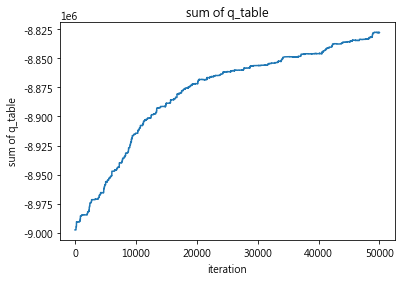

In [160]:
plt.xlabel("iteration")
plt.ylabel("sum of q_table")
plt.title("sum of q_table")
plt.plot(q_value)

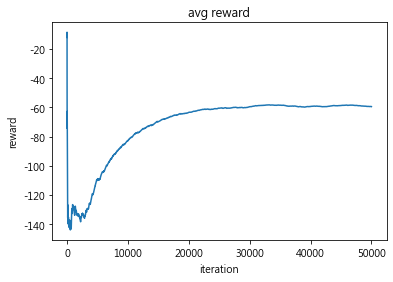

In [161]:
plt.xlabel("iteration")
plt.ylabel("reward")
plt.title("avg reward")
plt.plot(avg_reward_list)

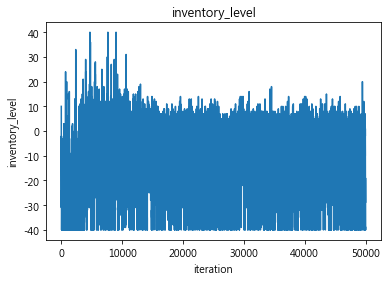

In [162]:
plt.xlabel("iteration")
plt.ylabel("inventory_level")
plt.title("inventory_level")
plt.plot(inventory_level_list)

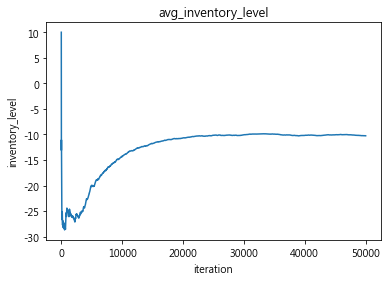

In [163]:
plt.xlabel("iteration")
plt.ylabel("inventory_level")
plt.title("avg_inventory_level")
plt.plot(avg_inventory_list)

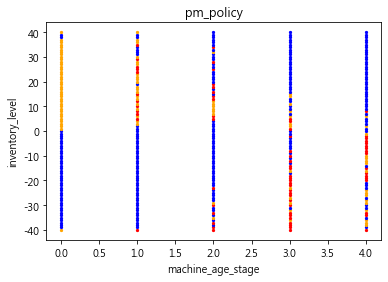

In [164]:
x = np.arange(0,6)
y = np.arange(-40,41)
fig, ax = plt.subplots()
red_patch = mpatches.Patch(color='red', label='pm')
blue_patch = mpatches.Patch(color='blue', label='production')
orange_patch = mpatches.Patch(color='orange', label='rest')
#ax.legend(handles=[orange_patch, red_patch, blue_patch])

for i in range(INVENTORY_LEVEL//2 * -1, INVENTORY_LEVEL//2+1):
    for j in range(STAGE-1):
        
        if j >= 1:
            production_value = q_table.loc[(j, i, 0), 0]
            pm_value = q_table.loc[(j, i, 0), 1]
            rest_value = q_table.loc[(j,i, 0), 4]

            if max(production_value, pm_value, rest_value) == production_value:
                ax.scatter(j,i, c='blue', s=5)
            elif max(production_value, pm_value, rest_value) == pm_value:
                ax.scatter(j,i,c='red',s=5)
            elif max(production_value, pm_value, rest_value) == rest_value:
                ax.scatter(j,i,c='orange', s=5)
            else:
                continue
        else:
            production_value = q_table.loc[(j, i, 0), 0]
            rest_value = q_table.loc[(j, i, 0), 4]
            if production_value > rest_value:
                ax.scatter(j,i, c='blue', s=5)
            elif production_value < rest_value:
                ax.scatter(j,i,c='orange', s=5)
            else:
                continue
                
plt.xlabel("machine_age_stage")
plt.ylabel("inventory_level")
plt.title("pm_policy")
plt.show()
        

In [113]:
q_table.loc[(2, 5,0)]

0     -11.048433
1      -8.478888
2   -1000.000000
3   -1000.000000
4      -5.037658
Name: (2, 5, 0), dtype: float64

In [131]:
MACHINE_DETERIORATION_RATE

[0.18126924692201818,
 0.3296799539643607,
 0.4511883639059736,
 0.5506710358827784,
 0.6321205588285577,
 0]